In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
final_df = pd.read_csv("datasets/final_in_possesion_df.csv")
team_ids = final_df['uniqueTeamId']
final_df.set_index("uniqueTeamId", inplace = True)
final_df.fillna(0, inplace=True)
final_df.head()

,ABAB,ABCA,ABCB,ABCD,Total_Passes,High_pass_Ratio_Total,Low_pass_Ratio_Total,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone2,High_pass_Ratio_Zone1,...,Side Pass_Zone_2 Ratio,Side Pass_Zone_3 Ratio,Backward Pass Ratio,Forward Pass Ratio,Side Pass Ratio,Total Shots,Far Shots Ratio,Middle Distance Shots Ratio,Near Shots Ratio,Connectivity
uniqueTeamId,,,,,,,,,,,,,,,,,,,,,
10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,0.198413,...,0.230303,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.500000,6.294872
10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,0.192000,...,0.246231,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.000000,6.659341
10531---2499741,0.022989,0.105747,0.105747,0.765517,438,0.146119,0.842466,0.130435,0.853755,0.197080,...,0.294521,0.043379,0.155251,0.349315,0.495434,6.0,0.166667,0.333333,0.500000,6.472527
10531---2499757,0.027344,0.103516,0.101562,0.767578,515,0.149515,0.829126,0.113744,0.867299,0.139535,...,0.205825,0.133981,0.163107,0.333981,0.502913,8.0,0.000000,0.625000,0.375000,7.153846
10531---2499766,0.032258,0.101382,0.105991,0.760369,220,0.240909,0.750000,0.134615,0.846154,0.351648,...,0.154545,0.077273,0.168182,0.450000,0.381818,3.0,0.000000,0.666667,0.333333,5.285714


In [41]:
final_df.columns

Index(['uniqueTeamId', 'ABAB', 'ABCA', 'ABCB', 'ABCD', 'Total_Passes',
       'High_pass_Ratio_Total', 'Low_pass_Ratio_Total',
       'High_pass_Ratio_Zone2', 'Low_pass_Ratio_Zone2',
       'High_pass_Ratio_Zone1', 'Low_pass_Ratio_Zone1',
       'High_pass_Ratio_Zone3', 'Low_pass_Ratio_Zone3',
       'Backward Pass_Zone_1 Ratio', 'Backward Pass_Zone_2 Ratio',
       'Backward Pass_Zone_3 Ratio', 'Forward Pass_Zone_1 Ratio',
       'Forward Pass_Zone_2 Ratio', 'Forward Pass_Zone_3 Ratio',
       'Side Pass_Zone_1 Ratio', 'Side Pass_Zone_2 Ratio',
       'Side Pass_Zone_3 Ratio', 'Backward Pass Ratio', 'Forward Pass Ratio',
       'Side Pass Ratio', 'Total Shots', 'Far Shots Ratio',
       'Middle Distance Shots Ratio', 'Near Shots Ratio', 'Connectivity'],
      dtype='object')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

    # Autoencoder for DEC
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


    # DEC model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters)**2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

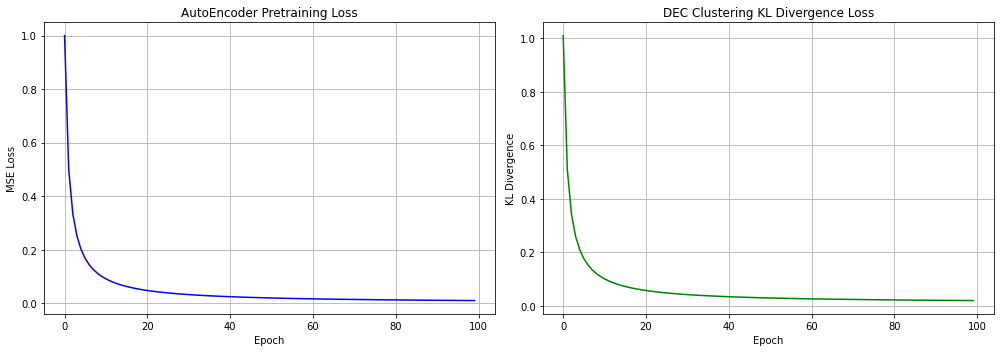

In [4]:
# Re-import necessary libraries after kernel reset
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Simulate dummy AE and KL loss lists for plotting purposes
ae_loss = [torch.tensor(1 / (i + 1)) for i in range(100)]
kl_loss = [torch.tensor(1 / (i + 1) + 0.01) for i in range(100)]

# Plot AE and KL loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot([l.item() for l in ae_loss], label="AE Loss", color='blue')
plt.title("AutoEncoder Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([l.item() for l in kl_loss], label="KL Loss", color='green')
plt.title("DEC Clustering KL Divergence Loss")
plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.grid(True)

plt.tight_layout()
plt.show()



# Better scatter plot with cluster coloring
#plt.figure(figsize=(8, 6))
#scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', s=100, edgecolors='k', alpha=0.8)
#plt.title("DEC Clustering Results in Latent Space", fontsize=14)
#plt.xlabel("Principal Component 1", fontsize=12)
#plt.ylabel("Principal Component 2", fontsize=12)
#plt.grid(True)
##plt.colorbar(scatter, ticks=range(4), label='Cluster')
#plt.tight_layout()
#plt.show()
#

Pretrain Epoch 0: Loss = 1.0047
Pretrain Epoch 250: Loss = 0.1438
Pretrain Epoch 500: Loss = 0.1289
Pretrain Epoch 750: Loss = 0.1240
Pretrain Epoch 1000: Loss = 0.1199
Pretrain Epoch 1250: Loss = 0.1182
Pretrain Epoch 1500: Loss = 0.1156
Pretrain Epoch 1750: Loss = 0.1138
Pretrain Epoch 2000: Loss = 0.1123
Pretrain Epoch 2250: Loss = 0.1111
Pretrain Epoch 2500: Loss = 0.1101
Pretrain Epoch 2750: Loss = 0.1091
DEC Epoch 0: Loss = 0.1122
DEC Epoch 250: Loss = 0.0839
DEC Epoch 500: Loss = 0.0545
DEC Epoch 750: Loss = 0.0434
DEC Epoch 1000: Loss = 0.0363
DEC Epoch 1250: Loss = 0.0315
DEC Epoch 1500: Loss = 0.0279
DEC Epoch 1750: Loss = 0.0251
DEC Epoch 2000: Loss = 0.0230
DEC Epoch 2250: Loss = 0.0210
DEC Epoch 2500: Loss = 0.0195
DEC Epoch 2750: Loss = 0.0180


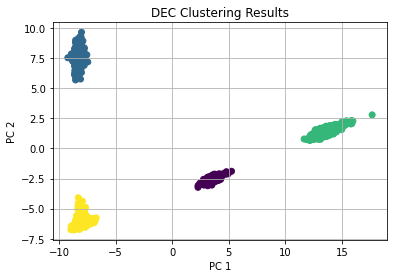

In [5]:
import random
from sklearn.decomposition import PCA

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
k=4

# If using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df)

pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X_scaled)

# Tensor version for PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


# DEC pretrain
input_dim = X_scaled.shape[1]
latent_dim = 10
ae = AutoEncoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

ae_loss = []
kl_loss = []

for epoch in range(3000):
    optimizer.zero_grad()
    output = ae(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 250 == 0:
        print(f"Pretrain Epoch {epoch}: Loss = {loss.item():.4f}")
        
    ae_loss.append(loss)

z = ae.encoder(X_tensor).detach().numpy()
kmeans = KMeans(n_clusters=k, random_state=42).fit(z)
initial_cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

dec = DEC(ae.encoder, initial_cluster_centers.clone())
dec_optimizer = optim.Adam(dec.parameters(), lr=1e-3)

for epoch in range(3000):
    q = dec(X_tensor)
    p = target_distribution(q.detach())
    loss = torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

    dec_optimizer.zero_grad()
    loss.backward()
    dec_optimizer.step()
    
    if epoch % 250 == 0:
        print(f"DEC Epoch {epoch}: Loss = {loss.item():.4f}")
    
    kl_loss.append(loss)

with torch.no_grad():
    z_final = dec.encoder(X_tensor)
    final_q = dec(X_tensor)
    labels = torch.argmax(final_q, dim=1).numpy()

sil_score = silhouette_score(z_final.numpy(), labels)

# Visualization
from sklearn.decomposition import PCA
z_pca = PCA(n_components=2).fit_transform(z_final.numpy())
plt.scatter(z_pca[:,0], z_pca[:,1], c=labels, cmap='viridis')
plt.title("DEC Clustering Results")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

# Assign clusters
df_with_labels = pd.DataFrame(X_scaled)
df_with_labels['Cluster'] = labels

In [6]:
sil_score

0.9512021

In [7]:
final_df_with_labels = final_df.copy()
final_df_with_labels['Cluster'] = labels

In [8]:
clustered_df_for_stats = final_df_with_labels.reset_index()
clustered_df_for_stats.rename(columns={'uniqueTeamId': 'TeamID'}, inplace=True)
clustered_df_for_stats

,TeamID,ABAB,ABCA,ABCB,ABCD,Total_Passes,High_pass_Ratio_Total,Low_pass_Ratio_Total,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone2,...,Side Pass_Zone_3 Ratio,Backward Pass Ratio,Forward Pass Ratio,Side Pass Ratio,Total Shots,Far Shots Ratio,Middle Distance Shots Ratio,Near Shots Ratio,Connectivity,Cluster
0,10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,...,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.500000,6.294872,0
1,10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,...,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.000000,6.659341,3
2,10531---2499741,0.022989,0.105747,0.105747,0.765517,438,0.146119,0.842466,0.130435,0.853755,...,0.043379,0.155251,0.349315,0.495434,6.0,0.166667,0.333333,0.500000,6.472527,3
3,10531---2499757,0.027344,0.103516,0.101562,0.767578,515,0.149515,0.829126,0.113744,0.867299,...,0.133981,0.163107,0.333981,0.502913,8.0,0.000000,0.625000,0.375000,7.153846,3
4,10531---2499766,0.032258,0.101382,0.105991,0.760369,220,0.240909,0.750000,0.134615,0.846154,...,0.077273,0.168182,0.450000,0.381818,3.0,0.000000,0.666667,0.333333,5.285714,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,756---2565880,0.029213,0.110112,0.112360,0.748315,448,0.214286,0.765625,0.122449,0.867347,...,0.165179,0.138393,0.314732,0.546875,19.0,0.210526,0.421053,0.368421,6.615385,0
3648,756---2565892,0.036842,0.113158,0.105263,0.744737,383,0.177546,0.812010,0.112299,0.871658,...,0.125326,0.140992,0.352480,0.506527,11.0,0.545455,0.272727,0.181818,7.362637,0
3649,756---2565904,0.031496,0.089239,0.089239,0.790026,384,0.270833,0.713542,0.135338,0.849624,...,0.111979,0.179688,0.346354,0.473958,14.0,0.000000,0.642857,0.357143,8.089744,2
3650,756---2565908,0.053608,0.098969,0.107216,0.740206,488,0.180328,0.805328,0.128631,0.854772,...,0.131148,0.172131,0.331967,0.495902,12.0,0.333333,0.500000,0.166667,7.153846,0


In [9]:
# List of columns to exclude from aggregation
cols_to_exclude = ['Cluster', 'TeamID']

# List of columns to include in the aggregation
cols_to_include = [col for col in clustered_df_for_stats.columns if col not in cols_to_exclude]

# Group by 'GMM_Labels' and calculate the mean and quantiles for each cluster
stats_per_cluster = clustered_df_for_stats.groupby('Cluster')[cols_to_include].agg('mean')
# Renaming the lambda functions for clarity in the output
#stats_per_cluster.columns = stats_per_cluster.columns.map('_'.join).str.replace('<lambda_0>', '25th_percentile').str.replace('<lambda_1>', '50th_percentile (median)').str.replace('<lambda_2>', '75th_percentile')
pd.set_option('display.max_columns', None)
stats_per_cluster

,ABAB,ABCA,ABCB,ABCD,Total_Passes,High_pass_Ratio_Total,Low_pass_Ratio_Total,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone2,High_pass_Ratio_Zone1,Low_pass_Ratio_Zone1,High_pass_Ratio_Zone3,Low_pass_Ratio_Zone3,Backward Pass_Zone_1 Ratio,Backward Pass_Zone_2 Ratio,Backward Pass_Zone_3 Ratio,Forward Pass_Zone_1 Ratio,Forward Pass_Zone_2 Ratio,Forward Pass_Zone_3 Ratio,Side Pass_Zone_1 Ratio,Side Pass_Zone_2 Ratio,Side Pass_Zone_3 Ratio,Backward Pass Ratio,Forward Pass Ratio,Side Pass Ratio,Total Shots,Far Shots Ratio,Middle Distance Shots Ratio,Near Shots Ratio,Connectivity
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.034535,0.092557,0.093067,0.779840,375.748201,0.170453,0.811965,0.107084,0.877453,0.233171,0.765064,0.215022,0.737672,0.025766,0.075776,0.045046,0.156298,0.163708,0.047504,0.144919,0.218222,0.122761,0.146587,0.367510,0.485903,10.098321,0.309947,0.413652,0.276401,7.288164
1,0.034551,0.097824,0.098409,0.769216,577.022051,0.101372,0.880274,0.061749,0.925957,0.119679,0.879062,0.163322,0.787462,0.017376,0.073206,0.052054,0.098692,0.152845,0.051410,0.132505,0.278200,0.143712,0.142635,0.302948,0.554417,14.270121,0.299777,0.410028,0.290194,8.094019
2,0.036726,0.085903,0.086824,0.790547,302.985885,0.212360,0.767614,0.135052,0.845064,0.292490,0.705629,0.244109,0.703341,0.029019,0.073234,0.041523,0.189318,0.170693,0.049727,0.137403,0.189953,0.119128,0.143777,0.409739,0.446485,9.096634,0.283865,0.471089,0.241789,6.658105
3,0.033048,0.095479,0.095917,0.775556,454.114141,0.136431,0.846149,0.088505,0.897689,0.173272,0.825415,0.194464,0.757097,0.023104,0.076744,0.047340,0.128086,0.164011,0.047021,0.145804,0.244098,0.123793,0.147188,0.339118,0.513694,10.826263,0.275638,0.473799,0.250563,7.740934


In [10]:
#stats_per_cluster.columns = stats_per_cluster.columns.map('_'.join).str.replace('<lambda_0>', '25th_percentile').str.replace('<lambda_1>', '50th_percentile (median)').str.replace('<lambda_2>', '75th_percentile')
pd.set_option('display.max_columns', None)
stats_per_cluster

,ABAB,ABCA,ABCB,ABCD,Total_Passes,High_pass_Ratio_Total,Low_pass_Ratio_Total,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone2,High_pass_Ratio_Zone1,Low_pass_Ratio_Zone1,High_pass_Ratio_Zone3,Low_pass_Ratio_Zone3,Backward Pass_Zone_1 Ratio,Backward Pass_Zone_2 Ratio,Backward Pass_Zone_3 Ratio,Forward Pass_Zone_1 Ratio,Forward Pass_Zone_2 Ratio,Forward Pass_Zone_3 Ratio,Side Pass_Zone_1 Ratio,Side Pass_Zone_2 Ratio,Side Pass_Zone_3 Ratio,Backward Pass Ratio,Forward Pass Ratio,Side Pass Ratio,Total Shots,Far Shots Ratio,Middle Distance Shots Ratio,Near Shots Ratio,Connectivity
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.034535,0.092557,0.093067,0.779840,375.748201,0.170453,0.811965,0.107084,0.877453,0.233171,0.765064,0.215022,0.737672,0.025766,0.075776,0.045046,0.156298,0.163708,0.047504,0.144919,0.218222,0.122761,0.146587,0.367510,0.485903,10.098321,0.309947,0.413652,0.276401,7.288164
1,0.034551,0.097824,0.098409,0.769216,577.022051,0.101372,0.880274,0.061749,0.925957,0.119679,0.879062,0.163322,0.787462,0.017376,0.073206,0.052054,0.098692,0.152845,0.051410,0.132505,0.278200,0.143712,0.142635,0.302948,0.554417,14.270121,0.299777,0.410028,0.290194,8.094019
2,0.036726,0.085903,0.086824,0.790547,302.985885,0.212360,0.767614,0.135052,0.845064,0.292490,0.705629,0.244109,0.703341,0.029019,0.073234,0.041523,0.189318,0.170693,0.049727,0.137403,0.189953,0.119128,0.143777,0.409739,0.446485,9.096634,0.283865,0.471089,0.241789,6.658105
3,0.033048,0.095479,0.095917,0.775556,454.114141,0.136431,0.846149,0.088505,0.897689,0.173272,0.825415,0.194464,0.757097,0.023104,0.076744,0.047340,0.128086,0.164011,0.047021,0.145804,0.244098,0.123793,0.147188,0.339118,0.513694,10.826263,0.275638,0.473799,0.250563,7.740934


In [11]:
stats_per_cluster[['Total_Passes', 'High_pass_Ratio_Total', 'Total Shots', 'Connectivity', 'ABCB']]

,Total_Passes,High_pass_Ratio_Total,Total Shots,Connectivity,ABCB
Cluster,,,,,
0,375.748201,0.170453,10.098321,7.288164,0.093067
1,577.022051,0.101372,14.270121,8.094019,0.098409
2,302.985885,0.212360,9.096634,6.658105,0.086824
3,454.114141,0.136431,10.826263,7.740934,0.095917


In [14]:
with open("../../matches/matches_England.json", "r") as file:
    matches_data_2 = json.load(file)

matches2 = pd.DataFrame(matches_data_2)

with open("../../matches/matches_France.json", "r") as file:
    matches_data_3 = json.load(file)

matches3 = pd.DataFrame(matches_data_3)

with open("../../matches/matches_Germany.json", "r") as file:
    matches_data_4 = json.load(file)

matches4 = pd.DataFrame(matches_data_4)

with open("../../matches/matches_Italy.json", "r") as file:
    matches_data_5 = json.load(file)

matches5 = pd.DataFrame(matches_data_5)

with open("../../matches/matches_Spain.json", "r") as file:
    matches_data_6 = json.load(file)

matches6 = pd.DataFrame(matches_data_6)

all_matches_df = pd.concat([matches2, matches3, matches4, matches5, matches6], ignore_index=True)

with open("../../events/teams.json", "r") as file:
    teams_data = json.load(file)

teams_df = pd.DataFrame(teams_data)

In [15]:
final_df = final_df.reset_index()
df_with_clusters = final_df.merge(clustered_df_for_stats, left_on='uniqueTeamId', right_on='TeamID')
df_with_clusters["matchId"] = df_with_clusters["uniqueTeamId"].str.split("---").str[1].astype(int)
df_with_clusters["teamId"] = df_with_clusters["uniqueTeamId"].str.split("---").str[0].astype(int)

In [16]:
matches_with_clusters = df_with_clusters.merge(all_matches_df, left_on='matchId', right_on='wyId')

In [17]:
matches_with_clusters

,uniqueTeamId,ABAB_x,ABCA_x,ABCB_x,ABCD_x,Total_Passes_x,High_pass_Ratio_Total_x,Low_pass_Ratio_Total_x,High_pass_Ratio_Zone2_x,Low_pass_Ratio_Zone2_x,High_pass_Ratio_Zone1_x,Low_pass_Ratio_Zone1_x,High_pass_Ratio_Zone3_x,Low_pass_Ratio_Zone3_x,Backward Pass_Zone_1 Ratio_x,Backward Pass_Zone_2 Ratio_x,Backward Pass_Zone_3 Ratio_x,Forward Pass_Zone_1 Ratio_x,Forward Pass_Zone_2 Ratio_x,Forward Pass_Zone_3 Ratio_x,Side Pass_Zone_1 Ratio_x,Side Pass_Zone_2 Ratio_x,Side Pass_Zone_3 Ratio_x,Backward Pass Ratio_x,Forward Pass Ratio_x,Side Pass Ratio_x,Total Shots_x,Far Shots Ratio_x,Middle Distance Shots Ratio_x,Near Shots Ratio_x,Connectivity_x,TeamID,ABAB_y,ABCA_y,ABCB_y,ABCD_y,Total_Passes_y,High_pass_Ratio_Total_y,Low_pass_Ratio_Total_y,High_pass_Ratio_Zone2_y,Low_pass_Ratio_Zone2_y,High_pass_Ratio_Zone1_y,Low_pass_Ratio_Zone1_y,High_pass_Ratio_Zone3_y,Low_pass_Ratio_Zone3_y,Backward Pass_Zone_1 Ratio_y,Backward Pass_Zone_2 Ratio_y,Backward Pass_Zone_3 Ratio_y,Forward Pass_Zone_1 Ratio_y,Forward Pass_Zone_2 Ratio_y,Forward Pass_Zone_3 Ratio_y,Side Pass_Zone_1 Ratio_y,Side Pass_Zone_2 Ratio_y,Side Pass_Zone_3 Ratio_y,Backward Pass Ratio_y,Forward Pass Ratio_y,Side Pass Ratio_y,Total Shots_y,Far Shots Ratio_y,Middle Distance Shots Ratio_y,Near Shots Ratio_y,Connectivity_y,Cluster,matchId,teamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,0.198413,0.793651,0.195122,0.804878,0.018182,0.115152,0.024242,0.172727,0.148485,0.018182,0.190909,0.230303,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.500000,6.294872,10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,0.198413,0.793651,0.195122,0.804878,0.018182,0.115152,0.024242,0.172727,0.148485,0.018182,0.190909,0.230303,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.500000,6.294872,0,2499726,10531,Played,4405654,1,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-12 14:00:00,0,St. Mary's Stadium,2499726,"Southampton - Swansea City, 0 - 0","August 12, 2017 at 4:00:00 PM GMT+2","[{'refereeId': 385916, 'role': 'referee'}, {'r...",Regular,364
1,1619---2499726,0.039683,0.081349,0.085317,0.793651,507,0.136095,0.838264,0.065217,0.930435,0.215054,0.784946,0.184783,0.750000,0.011834,0.076923,0.074951,0.092702,0.130178,0.082840,0.078895,0.246548,0.205128,0.163708,0.305720,0.530572,25.0,0.280000,0.440000,0.280000,7.758242,1619---2499726,0.039683,0.081349,0.085317,0.793651,507,0.136095,0.838264,0.065217,0.930435,0.215054,0.784946,0.184783,0.750000,0.011834,0.076923,0.074951,0.092702,0.130178,0.082840,0.078895,0.246548,0.205128,0.163708,0.305720,0.530572,25.0,0.280000,0.440000,0.280000,7.758242,1,2499726,1619,Played,4405654,1,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-12 14:00:00,0,St. Mary's Stadium,2499726,"Southampton - Swansea City, 0 - 0","August 12, 2017 at 4:00:00 PM GMT+2","[{'refereeId': 385916, 'role': 'referee'}, {'r...",Regular,364
2,10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,0.192000,0.808000,0.195876,0.773196,0.027638,0.065327,0.062814,0.133166,0.130653,0.040201,0.153266,0.246231,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.000000,6.659341,10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,0.192000,0.808000,0.195876,0.773196,0.027638,0.065327,0.062814,0.133166,0.130653,0.040201,0.153266,0.246231,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.000000,6.659341,3,2499736,10531,Played,4405654,2,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-19 11:30:00,1611,Liberty Stadium,2499736,"Swansea City - Manchester United, 0 - 4","August 19, 2017 at 1:30:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
3,1611---2499736,0.054577,0.093310,0.100352,0.751761,571,0.084063,0.8949

In [18]:
labeled_team_df = matches_with_clusters.loc[:,['uniqueTeamId', 'matchId', 'teamId', 'Cluster']]

In [19]:
unique, counts = np.unique(labeled_team_df.Cluster, return_counts=True)
dict(zip(unique, counts))

{0: 834, 1: 907, 2: 921, 3: 990}

In [20]:
# Step 1: Aggregate data by 'teamId' and 'Cluster' and count occurrences
label_counts = labeled_team_df.groupby(['teamId', 'Cluster']).size().reset_index(name='counts')

# Step 2: Calculate probability of each label for each team
total_counts = labeled_team_df['teamId'].value_counts().reset_index()
total_counts.columns = ['teamId', 'total']

# Merge counts with total counts to calculate probabilities
label_prob = pd.merge(label_counts, total_counts, on='teamId')
label_prob['probability'] = label_prob['counts'] / label_prob['total']

# Pivot the data to have labels as columns
prob_pivot = label_prob.pivot(index='teamId', columns='Cluster', values='probability').fillna(0)

prob_pivot['max_label'] = prob_pivot.iloc[:, :-1].idxmax(axis=1)


# Ensuring all labels are represented
all_labels = sorted(labeled_team_df['Cluster'].unique())
for label in all_labels:
    if label not in prob_pivot.columns:
        prob_pivot[label] = 0  # Add missing label columns with 0 probability

# Now, recalculate max_label
prob_pivot['max_label'] = prob_pivot[all_labels].idxmax(axis=1)

# The updated DataFrame prob_pivot should now correctly reflect the max_label including label '3'
majority_voting_res = prob_pivot

majority_voting_res = majority_voting_res.reset_index()

In [21]:
teams_df = teams_df.loc[:,["wyId", "name"]]

merged_df_tmp = pd.merge(majority_voting_res, teams_df, left_on='teamId', right_on='wyId', how='left')

# Selecting the columns to include in the final DataFrame (if needed to remove the ID from df2)
majority_voting_res_named = merged_df_tmp.drop(columns=['wyId'])

In [22]:
pd.set_option('display.max_rows', None)
majority_voting_res_named[['max_label','name']]

,max_label,name
0,3,Valencia
1,1,Real Madrid
2,1,Barcelona
3,0,Deportivo La Coru\u00f1a
4,0,Athletic Club
5,3,Atl\u00e9tico Madrid
6,3,Sevilla
7,3,Villarreal
8,2,M\u00e1laga
9,1,Real Betis


In [23]:
matches_with_clusters['Match_Result'] = matches_with_clusters.apply(
    lambda row: 'Draw' if row['winner'] == 0 else ('Win' if row['winner'] == row['teamId'] else 'Lose'), axis=1)

# Group by cluster label and match result
outcome_counts = matches_with_clusters.groupby(['Cluster', 'Match_Result']).size().unstack(fill_value=0)

# Calculate percentages
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

In [24]:
outcome_percentages

Match_Result,Draw,Lose,Win
Cluster,,,
0,28.657074,41.007194,30.335731
1,20.396913,27.894157,51.708931
2,27.252986,39.413681,33.333333
3,23.535354,41.818182,34.646465


In [25]:
# Map each team to its cluster
team_to_cluster_map = dict(zip(clustered_df_for_stats['TeamID'], clustered_df_for_stats['Cluster']))

# Create a function to get opponent cluster
def get_opponent_cluster(row):
    for team in row['teamsData']:
        if int(team) != int(row['teamId']):
            t = str(team)
            m = str(row['matchId'])
            g = t + "---" + m
            return team_to_cluster_map.get(g)
    

matches_with_clusters['Opponent_Cluster'] = matches_with_clusters.apply(get_opponent_cluster, axis=1)

In [26]:
# Grouping by cluster and opponent cluster
grouped = matches_with_clusters.groupby(['Cluster', 'Opponent_Cluster', 'Match_Result'])

# Counting occurrences
outcome_counts = grouped.size().unstack(fill_value=0)

# Calculating percentages
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Reshaping for a 9x3 matrix
outcome_matrix = outcome_percentages.unstack()

In [27]:
outcome_matrix

Match_Result           Draw                                        Lose  \
Opponent_Cluster          0          1          2          3          0   
Cluster                                                                   
0                 34.951456  22.660099  30.726257  26.829268  32.524272   
1                 22.660099  11.688312  24.418605  17.961165  20.689655   
2                 30.726257  24.418605  31.325301  25.862069  29.608939   
3                 26.829268  17.961165  25.862069  22.875817  36.991870   

Match_Result                                             Win             \
Opponent_Cluster          1          2          3          0          1   
Cluster                                                                   
0                 56.650246  39.664804  36.178862  32.524272  20.689655   
1                 44.155844  25.581395  26.699029  56.650246  44.155844   
2                 50.000000  34.337349  34.913793  39.664804  25.581395   
3                 55.339806  39.224138  38.562092  36.178862  26.699029   

Match_Result                            
Opponent_Cluster          2          3  
Cluster                                 
0                 29.608939  36.991870  
1                 50.000000  55.339806  
2                 34.337349  39.224138  
3                 34.913793  38.562092

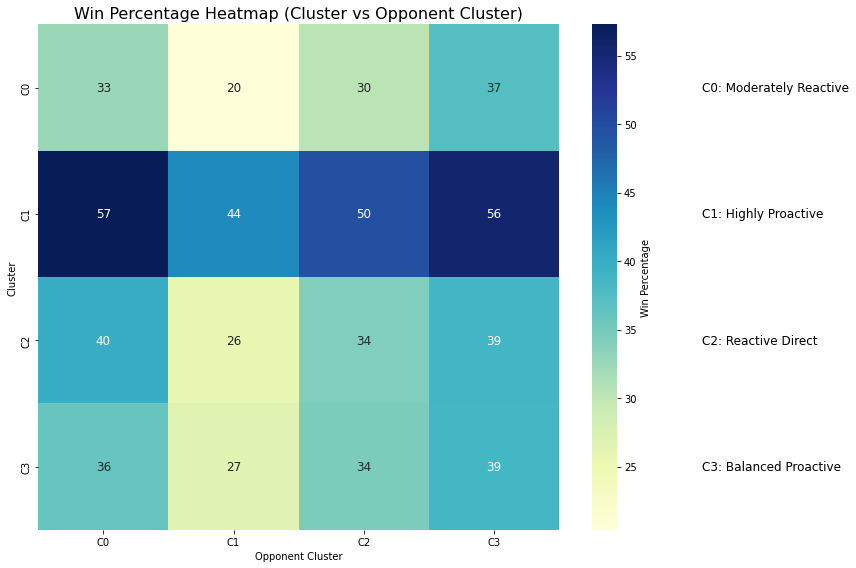

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the win matrix (taken from the df above)
win_data = [
    [32.524272, 20.388350, 30.337079, 37.295082],
    [57.281553, 44.155844, 49.560117, 55.555556],
    [39.887640, 25.806452, 34.146341, 38.723404],
    [36.065574, 26.570048, 34.468085, 38.562092]
]

# Create a DataFrame for the win matrix
win_df = pd.DataFrame(win_data, columns=[0, 1, 2, 3], index=[0, 1, 2, 3])

# Restore simplified cluster labels for the heatmap
simple_labels = ['C0', 'C1', 'C2', 'C3']
win_df.index = simple_labels
win_df.columns = simple_labels

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(win_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Win Percentage'}, annot_kws={"size": 12})
plt.title('Win Percentage Heatmap (Cluster vs Opponent Cluster)', fontsize=16)
plt.xlabel('Opponent Cluster')
plt.ylabel('Cluster')

# Add custom legend for cluster meanings
legend_labels = [
    "C0: Moderately Reactive",
    "C1: Highly Proactive",
    "C2: Reactive Direct",
    "C3: Balanced Proactive"
]
for i, label in enumerate(legend_labels):
    plt.text(5.1, i + 0.5, label, va='center', fontsize=12)

plt.tight_layout()
plt.show()


# STYLE CHANGERS

In [51]:
import pandas as pd
import numpy as np
import torch

WINDOWS = [
"final_in_poss_df_1H_0_15.csv",
"final_in_poss_df_1H_15_30.csv",
"final_in_poss_df_1H_30_45.csv",
"final_in_poss_df_2H_0_15.csv",
"final_in_poss_df_2H_15_30.csv",
"final_in_poss_df_2H_30_45.csv"
]

WINDOW_LENGTHS = {
    "final_in_poss_df_1H_0_15.csv": 15,
    "final_in_poss_df_1H_15_30.csv": 15,
    "final_in_poss_df_1H_30_45.csv": 16, # avg +1 extra time
    "final_in_poss_df_2H_0_15.csv": 15,
    "final_in_poss_df_2H_15_30.csv": 15,
    "final_in_poss_df_2H_30_45.csv": 17 # avg +2 extra time
}

COUNT_FEATURES = ["Total_Passes", "Total Shots"]
CONNECTIVITY_ALPHA = 0.4


FEATURE_COLS = final_df.select_dtypes(include=[np.number]).columns.tolist()

def parse_ids(df):
    # expects uniqueTeamId like "teamId---matchId"
    out = df.copy()
    out["matchId"] = out["uniqueTeamId"].str.split("---").str[1].astype(int)
    out["teamId"]  = out["uniqueTeamId"].str.split("---").str[0].astype(int)
    return out

def majority_vote(series):
    # deterministic tie-break: smallest cluster id
    vc = series.value_counts()
    top = vc[vc == vc.max()].index
    return int(np.min(top))

import numpy as np
import pandas as pd
import torch

def infer_clusters_for_df(df_any, scaler, dec_model, feature_cols, device="cpu", id_col="uniqueTeamId"):
    df = df_any.copy()

    # ids
    if id_col in df.columns:
        ids = df[id_col].astype(str)
        df = df.drop(columns=[id_col])
    else:
        ids = df.index.astype(str)

    # align columns to training features
    for c in feature_cols:
        if c not in df.columns:
            df[c] = 0.0
    X = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()

    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    dec_model.eval()
    with torch.no_grad():
        q = dec_model(X_tensor)
        labels = torch.argmax(q, dim=1).cpu().numpy()

    return pd.DataFrame({"uniqueTeamId": ids, "Cluster": labels}).set_index("uniqueTeamId")



def team_majority_style(labeled_df):
    """
    labeled_df: index uniqueTeamId, column Cluster
    returns: DataFrame [teamId, majority_cluster]
    """
    tmp = labeled_df.reset_index()
    tmp = parse_ids(tmp)
    maj = tmp.groupby("teamId")["Cluster"].apply(majority_vote).reset_index()
    maj.rename(columns={"Cluster": "majority_cluster"}, inplace=True)
    return maj

def compute_change_count(team_window_styles_df):
    """
    team_window_styles_df has columns: teamId, h1_0_15, ..., h2_30_45
    returns: Series of change counts
    """
    arr = team_window_styles_df[WINDOWS].values
    # count transitions where next != current
    changes = (arr[:, 1:] != arr[:, :-1]).sum(axis=1)
    return pd.Series(changes, index=team_window_styles_df.index)

# -------------------------
# 1) FULL baseline styles
# -------------------------
# final_df is your full feature table indexed by uniqueTeamId (as in your script) :contentReference[oaicite:3]{index=3}
FEATURE_COLS = final_df.select_dtypes(include=[np.number]).columns.tolist()

full_labeled = infer_clusters_for_df(final_df, scaler, dec, FEATURE_COLS)

# for each window dfw:
full_team_style = team_majority_style(full_labeled).rename(columns={"majority_cluster":"full_style"})

# -------------------------
# 2) Window styles (frozen inference)
# -------------------------
window_team_styles = []
for w in WINDOWS:
    dfw = pd.read_csv(f"datasets/{w}")

    t = WINDOW_LENGTHS[w]

    # normalize true counts
    for c in COUNT_FEATURES:
        if c in dfw.columns:
            dfw[c] = dfw[c] * (90 / t)

    # normalize connectivity (sublinear)
    if "Connectivity" in dfw.columns:
        dfw["Connectivity"] = dfw["Connectivity"] * (90 / t) ** CONNECTIVITY_ALPHA

    dfw = dfw.set_index("uniqueTeamId").fillna(0)

    labeled_w = infer_clusters_for_df(dfw, scaler, dec, FEATURE_COLS)
    team_style_w = team_majority_style(labeled_w)
    team_style_w.rename(columns={"majority_cluster": w}, inplace=True)
    window_team_styles.append(team_style_w)

# Merge all window majority styles into one table
team_styles = window_team_styles[0]
for nxt in window_team_styles[1:]:
    team_styles = team_styles.merge(nxt, on="teamId", how="outer")

# some teams might be missing from some windows (depends on your data creation)
# choose a rule:
# - keep NaN (and skip those transitions), OR
# - fill with full_style later
team_styles = team_styles.merge(full_team_style, on="teamId", how="left")

for w in WINDOWS:
    team_styles[w] = team_styles[w].fillna(team_styles["full_style"]).astype(int)

team_styles["change_count"] = compute_change_count(team_styles)

team_styles["diff_from_full_count"] = (team_styles[WINDOWS].values != team_styles["full_style"].values[:,None]).sum(axis=1)

# -------------------------
# 3) Team win rate
# -------------------------
# You already compute Match_Result at (team, match) level in matches_with_clusters :contentReference[oaicite:4]{index=4}
# Recreate a lightweight match result table and aggregate to teamId:
# matches_with_clusters must have: teamId, matchId, winner (and ideally teamsData logic already present)
tmp = matches_with_clusters.copy()
tmp["Match_Result"] = tmp.apply(
    lambda row: "Draw" if row["winner"] == 0 else ("Win" if row["winner"] == row["teamId"] else "Lose"),
    axis=1
)
team_outcomes = tmp.groupby("teamId")["Match_Result"].value_counts().unstack(fill_value=0)
team_outcomes["matches"] = team_outcomes.sum(axis=1)
team_outcomes["win_rate"] = team_outcomes.get("Win",0) / team_outcomes["matches"]

team_success = team_outcomes.reset_index()[["teamId","win_rate","matches"]]

# -------------------------
# 4) Final dataset + comparisons
# -------------------------
final_team_df = team_styles.merge(team_success, on="teamId", how="left")

final_team_df["changer_flag"] = np.where(final_team_df["change_count"] > 0, "Changer", "Sticker")

print(final_team_df.groupby("changer_flag")["win_rate"].agg(["count","mean","median"]))
print(final_team_df[["change_count","win_rate"]].corr(numeric_only=True))

c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler wa

              count      mean    median
changer_flag                           
Changer          55  0.353532  0.315789
Sticker          43  0.403377  0.368421
              change_count  win_rate
change_count      1.000000 -0.213543
win_rate         -0.213543  1.000000


In [52]:
team_styles

,teamId,final_in_poss_df_1H_0_15.csv,final_in_poss_df_1H_15_30.csv,final_in_poss_df_1H_30_45.csv,final_in_poss_df_2H_0_15.csv,final_in_poss_df_2H_15_30.csv,final_in_poss_df_2H_30_45.csv,full_style,change_count,diff_from_full_count
0,674,3,3,3,1,3,3,3,2,1
1,675,1,1,1,1,1,1,1,0,0
2,676,1,1,1,1,3,1,1,2,1
3,677,2,3,2,2,3,2,0,4,6
4,678,3,2,2,2,2,3,0,2,6
5,679,3,3,3,3,3,3,3,0,0
6,680,3,3,3,3,3,3,3,0,0
7,682,3,3,3,3,3,3,3,0,0
8,683,2,2,2,2,2,2,2,0,0
9,684,1,1,1,1,3,3,1,1,2


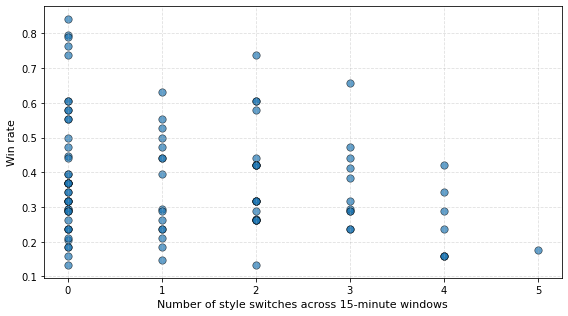

In [53]:
x = final_team_df["change_count"]
y = final_team_df["win_rate"]

plt.figure(figsize=(8, 4.5))

plt.scatter(
    x,
    y,
    alpha=0.7,
    s=55,
    edgecolors="black",
    linewidth=0.6
)

# X-axis: force integer ticks only
x_min, x_max = int(x.min()), int(x.max())
plt.xticks(np.arange(x_min, x_max + 1, 1))

plt.xlabel("Number of style switches across 15-minute windows", fontsize=11)
plt.ylabel("Win rate", fontsize=11)

plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [54]:
from scipy.stats import spearmanr

rho, p = spearmanr(final_team_df["change_count"], final_team_df["win_rate"])
print(f"Spearman rho = {rho:.3f}, p = {p:.4f}")

Spearman rho = -0.168, p = 0.0990


In [56]:
from scipy.stats import mannwhitneyu

a = final_team_df.loc[final_team_df["change_count"] == 0, "win_rate"]
b = final_team_df.loc[final_team_df["change_count"] > 0, "win_rate"]

u, p = mannwhitneyu(a, b, alternative="two-sided")
print("U:", u, "p:", p)


U: 1348.5 p: 0.23546778023964354


In [57]:
import numpy as np

print("Var (0 switches):", np.var(a, ddof=1))
print("Var (>0 switches):", np.var(b, ddof=1))


Var (0 switches): 0.03468448855682043
Var (>0 switches): 0.02060881574679272


In [65]:
import statsmodels.api as sm

X = final_team_df["change_count"]
X2 = X**2
X_design = sm.add_constant(np.column_stack([X, X2]))
y = final_team_df["win_rate"]

model = sm.OLS(y, X_design).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.873
Date:                Sat, 10 Jan 2026   Prob (F-statistic):             0.0615
Time:                        16:58:08   Log-Likelihood:                 41.110
No. Observations:                  98   AIC:                            -76.22
Df Residuals:                      95   BIC:                            -68.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3976      0.024     16.564      0.0

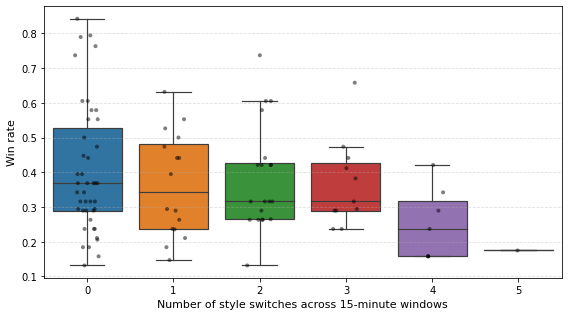

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure change_count is integer
final_team_df["change_count"] = final_team_df["change_count"].astype(int)

# Sort for cleaner x-axis
order = sorted(final_team_df["change_count"].unique())

plt.figure(figsize=(8, 4.5))

sns.boxplot(
    data=final_team_df,
    x="change_count",
    y="win_rate",
    order=order,
    showfliers=False,        # hide outliers for clarity
    linewidth=1.2
)

sns.stripplot(
    data=final_team_df,
    x="change_count",
    y="win_rate",
    order=order,
    color="black",
    alpha=0.5,
    size=4,
    jitter=0.15
)

plt.xlabel("Number of style switches across 15-minute windows", fontsize=11)
plt.ylabel("Win rate", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [66]:
# Make baseline cluster categorical
final_team_df["full_style"] = final_team_df["full_style"].astype(int)

# Sanity check
final_team_df.groupby("full_style").size()

full_style
0    17
1    25
2    29
3    27
dtype: int64

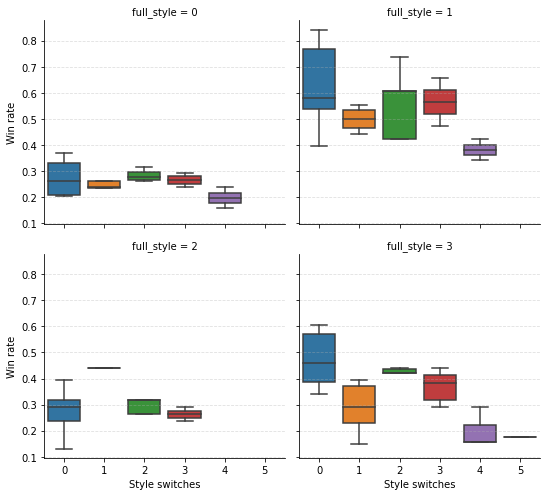

In [68]:
g = sns.catplot(
    data=final_team_df,
    x="change_count",
    y="win_rate",
    col="full_style",
    col_wrap=2,
    kind="box",
    showfliers=False,
    height=3.5,
    aspect=1.1
)

for ax in g.axes.flat:
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_xlabel("Style switches")
    ax.set_ylabel("Win rate")

plt.tight_layout()
plt.show()


# Match Level Change Analysis

In [69]:
def infer_window_clusters_match_level(dfw, scaler, dec, feature_cols):
    labeled = infer_clusters_for_df(dfw, scaler, dec, feature_cols)
    tmp = labeled.reset_index()
    tmp = parse_ids(tmp)
    return tmp[["teamId", "matchId", "Cluster"]]

In [70]:
window_match_labels = []

for w in WINDOWS:
    dfw = pd.read_csv(f"datasets/{w}")
    t = WINDOW_LENGTHS[w]

    # normalize counts
    for c in COUNT_FEATURES:
        if c in dfw.columns:
            dfw[c] = dfw[c] * (90 / t)

    # normalize connectivity
    if "Connectivity" in dfw.columns:
        dfw["Connectivity"] = dfw["Connectivity"] * (90 / t) ** CONNECTIVITY_ALPHA

    dfw = dfw.set_index("uniqueTeamId").fillna(0)

    tmp = infer_window_clusters_match_level(dfw, scaler, dec, FEATURE_COLS)
    tmp["window"] = w
    window_match_labels.append(tmp)

window_match_df = pd.concat(window_match_labels, ignore_index=True)

c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\users\eged1\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler wa

In [75]:
window_match_df .head()

,teamId,matchId,Cluster,window
0,10531,2499726,3,final_in_poss_df_1H_0_15.csv
1,10531,2499736,3,final_in_poss_df_1H_0_15.csv
2,10531,2499741,1,final_in_poss_df_1H_0_15.csv
3,10531,2499757,1,final_in_poss_df_1H_0_15.csv
4,10531,2499766,3,final_in_poss_df_1H_0_15.csv


In [73]:
WINDOW_ORDER = WINDOWS  # already in chronological order

def match_style_switches(sub_df):
    # ensure correct order
    sub_df = sub_df.set_index("window").loc[WINDOW_ORDER]
    clusters = sub_df["Cluster"].values
    return np.sum(clusters[1:] != clusters[:-1])

match_switch_df = (
    window_match_df
    .groupby(["teamId", "matchId"])
    .apply(match_style_switches)
    .reset_index(name="match_change_count")
)


In [93]:
matches_with_clusters.head()

,uniqueTeamId,ABAB_x,ABCA_x,ABCB_x,ABCD_x,Total_Passes_x,High_pass_Ratio_Total_x,Low_pass_Ratio_Total_x,High_pass_Ratio_Zone2_x,Low_pass_Ratio_Zone2_x,High_pass_Ratio_Zone1_x,Low_pass_Ratio_Zone1_x,High_pass_Ratio_Zone3_x,Low_pass_Ratio_Zone3_x,Backward Pass_Zone_1 Ratio_x,Backward Pass_Zone_2 Ratio_x,Backward Pass_Zone_3 Ratio_x,Forward Pass_Zone_1 Ratio_x,Forward Pass_Zone_2 Ratio_x,Forward Pass_Zone_3 Ratio_x,Side Pass_Zone_1 Ratio_x,Side Pass_Zone_2 Ratio_x,Side Pass_Zone_3 Ratio_x,Backward Pass Ratio_x,Forward Pass Ratio_x,Side Pass Ratio_x,Total Shots_x,Far Shots Ratio_x,Middle Distance Shots Ratio_x,Near Shots Ratio_x,Connectivity_x,TeamID,ABAB_y,ABCA_y,ABCB_y,ABCD_y,Total_Passes_y,High_pass_Ratio_Total_y,Low_pass_Ratio_Total_y,High_pass_Ratio_Zone2_y,Low_pass_Ratio_Zone2_y,High_pass_Ratio_Zone1_y,Low_pass_Ratio_Zone1_y,High_pass_Ratio_Zone3_y,Low_pass_Ratio_Zone3_y,Backward Pass_Zone_1 Ratio_y,Backward Pass_Zone_2 Ratio_y,Backward Pass_Zone_3 Ratio_y,Forward Pass_Zone_1 Ratio_y,Forward Pass_Zone_2 Ratio_y,Forward Pass_Zone_3 Ratio_y,Side Pass_Zone_1 Ratio_y,Side Pass_Zone_2 Ratio_y,Side Pass_Zone_3 Ratio_y,Backward Pass Ratio_y,Forward Pass Ratio_y,Side Pass Ratio_y,Total Shots_y,Far Shots Ratio_y,Middle Distance Shots Ratio_y,Near Shots Ratio_y,Connectivity_y,Cluster,matchId,teamId,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,Match_Result,Opponent_Cluster
0,10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,0.198413,0.793651,0.195122,0.804878,0.018182,0.115152,0.024242,0.172727,0.148485,0.018182,0.190909,0.230303,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.50,6.294872,10531---2499726,0.039755,0.091743,0.088685,0.779817,330,0.127273,0.869697,0.055215,0.944785,0.198413,0.793651,0.195122,0.804878,0.018182,0.115152,0.024242,0.172727,0.148485,0.018182,0.190909,0.230303,0.081818,0.157576,0.339394,0.503030,4.0,0.250000,0.250000,0.50,6.294872,0,2499726,10531,Played,4405654,1,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-12 14:00:00,0,St. Mary's Stadium,2499726,"Southampton - Swansea City, 0 - 0","August 12, 2017 at 4:00:00 PM GMT+2","[{'refereeId': 385916, 'role': 'referee'}, {'r...",Regular,364,Draw,1
1,1619---2499726,0.039683,0.081349,0.085317,0.793651,507,0.136095,0.838264,0.065217,0.930435,0.215054,0.784946,0.184783,0.750000,0.011834,0.076923,0.074951,0.092702,0.130178,0.082840,0.078895,0.246548,0.205128,0.163708,0.305720,0.530572,25.0,0.280000,0.440000,0.28,7.758242,1619---2499726,0.039683,0.081349,0.085317,0.793651,507,0.136095,0.838264,0.065217,0.930435,0.215054,0.784946,0.184783,0.750000,0.011834,0.076923,0.074951,0.092702,0.130178,0.082840,0.078895,0.246548,0.205128,0.163708,0.305720,0.530572,25.0,0.280000,0.440000,0.28,7.758242,1,2499726,1619,Played,4405654,1,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-12 14:00:00,0,St. Mary's Stadium,2499726,"Southampton - Swansea City, 0 - 0","August 12, 2017 at 4:00:00 PM GMT+2","[{'refereeId': 385916, 'role': 'referee'}, {'r...",Regular,364,Draw,0
2,10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,0.192000,0.808000,0.195876,0.773196,0.027638,0.065327,0.062814,0.133166,0.130653,0.040201,0.153266,0.246231,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.00,6.659341,10531---2499736,0.045570,0.106329,0.103797,0.744304,398,0.140704,0.844221,0.073864,0.909091,0.192000,0.808000,0.195876,0.773196,0.027638,0.065327,0.062814,0.133166,0.130653,0.040201,0.153266,0.246231,0.140704,0.155779,0.304020,0.540201,7.0,0.428571,0.571429,0.00,6.659341,3,2499736,10531,Played,4405654,2,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",181150,2017-08-19 11:30:00,1611,Liberty Stadium,2499736,"Swansea City - Manchester United, 0 - 4","August 19, 2017 at 1:30:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364,Lose,1
3,1611---2499736,0.054577,0.093310,0.100352,0

In [76]:
c = matches_with_clusters.copy()
match_outcomes["Loss"] = (
    (match_outcomes["winner"] != 0) &
    (match_outcomes["winner"] != match_outcomes["teamId"])
).astype(int)

match_level_df = match_switch_df.merge(
    match_outcomes[["teamId", "matchId", "Loss"]],
    on=["teamId", "matchId"],
    how="left"
)
match_level_df.head()

,teamId,matchId,match_change_count,Loss
0,674,2565556,3,0
1,674,2565564,1,0
2,674,2565570,2,0
3,674,2565587,4,0
4,674,2565595,2,0


In [78]:
match_level_df["match_change_count"].describe()

count    3652.000000
mean        2.843921
std         1.318083
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: match_change_count, dtype: float64

In [79]:
match_level_df["Loss"].mean()

0.37568455640744797

In [80]:
match_level_df.groupby("match_change_count")["Loss"].mean()

match_change_count
0    0.272321
1    0.297935
2    0.364428
3    0.360656
4    0.433114
5    0.440476
Name: Loss, dtype: float64

In [81]:
import statsmodels.api as sm

X = match_level_df["match_change_count"]
X = sm.add_constant(X)
y = match_level_df["Loss"]

logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())


                           Logit Regression Results                           
Dep. Variable:                   Loss   No. Observations:                 3652
Model:                          Logit   Df Residuals:                     3650
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                0.007246
Time:                        17:05:32   Log-Likelihood:                -2399.8
converged:                       True   LL-Null:                       -2417.3
Covariance Type:            nonrobust   LLR p-value:                 3.241e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.9551      0.084    -11.305      0.000      -1.121      -0.790
match_change_count     0.1554      0.026      5.864      0.000       0.103       0.207


In [82]:
np.exp(logit.params)


const                 0.384774
match_change_count    1.168070
dtype: float64

In [83]:
from scipy.stats import mannwhitneyu

loss0 = match_level_df.loc[match_level_df["match_change_count"] == 0, "Loss"]
loss1 = match_level_df.loc[match_level_df["match_change_count"] > 0, "Loss"]

u, p = mannwhitneyu(loss0, loss1)
print("U:", u, "p:", p)
print("Loss rate (0 switches):", loss0.mean())
print("Loss rate (>0 switches):", loss1.mean())


U: 341658.0 p: 0.000978890563437525
Loss rate (0 switches): 0.27232142857142855
Loss rate (>0 switches): 0.382438739789965


In [84]:
match_level_df = match_level_df.merge(
    final_team_df[["teamId", "win_rate"]],
    on="teamId",
    how="left"
)

X = match_level_df[["match_change_count", "win_rate"]]
X = sm.add_constant(X)
y = match_level_df["Loss"]

logit_ctrl = sm.Logit(y, X).fit(disp=False)
print(logit_ctrl.summary())


                           Logit Regression Results                           
Dep. Variable:                   Loss   No. Observations:                 3652
Model:                          Logit   Df Residuals:                     3649
Method:                           MLE   Df Model:                            2
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                 0.07063
Time:                        17:05:57   Log-Likelihood:                -2246.6
converged:                       True   LL-Null:                       -2417.3
Covariance Type:            nonrobust   LLR p-value:                 7.104e-75
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6860      0.129      5.313      0.000       0.433       0.939
match_change_count     0.1063      0.028      3.831      0.000       0.052       0.161
win_rate            

In [97]:
match_level_df.head()

,teamId,matchId,match_change_count,Loss,win_rate,adaptive_flag
0,674,2565556,3,0,0.578947,≥1 switch
1,674,2565564,1,0,0.578947,≥1 switch
2,674,2565570,2,0,0.578947,≥1 switch
3,674,2565587,4,0,0.578947,≥1 switch
4,674,2565595,2,0,0.578947,≥1 switch


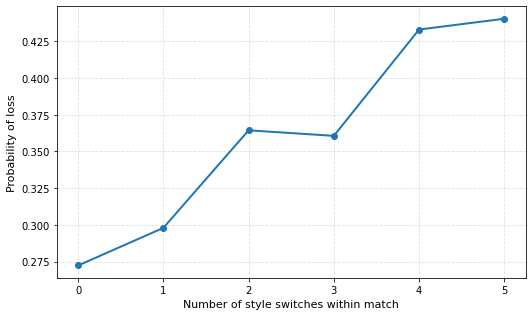

In [90]:
loss_by_switch = (
    match_level_df
    .groupby("match_change_count")["Loss"]
    .mean()
    .reset_index()
)


x = loss_by_switch["match_change_count"].to_numpy()
y = loss_by_switch["Loss"].to_numpy()

plt.figure(figsize=(7.5, 4.5))

plt.plot(x, y, marker="o", linewidth=2)

plt.xlabel("Number of style switches within match", fontsize=11)
plt.ylabel("Probability of loss", fontsize=11)

plt.xticks(x)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [89]:
match_level_df

,teamId,matchId,match_change_count,Loss,win_rate,adaptive_flag
0,674,2565556,3,0,0.578947,≥1 switch
1,674,2565564,1,0,0.578947,≥1 switch
2,674,2565570,2,0,0.578947,≥1 switch
3,674,2565587,4,0,0.578947,≥1 switch
4,674,2565595,2,0,0.578947,≥1 switch
5,674,2565607,4,0,0.578947,≥1 switch
6,674,2565608,5,0,0.578947,≥1 switch
7,674,2565620,5,0,0.578947,≥1 switch
8,674,2565632,3,0,0.578947,≥1 switch
9,674,2565638,4,0,0.578947,≥1 switch


In [94]:
match_level_df.head()

,teamId,matchId,match_change_count,Loss,win_rate,adaptive_flag
0,674,2565556,3,0,0.578947,≥1 switch
1,674,2565564,1,0,0.578947,≥1 switch
2,674,2565570,2,0,0.578947,≥1 switch
3,674,2565587,4,0,0.578947,≥1 switch
4,674,2565595,2,0,0.578947,≥1 switch


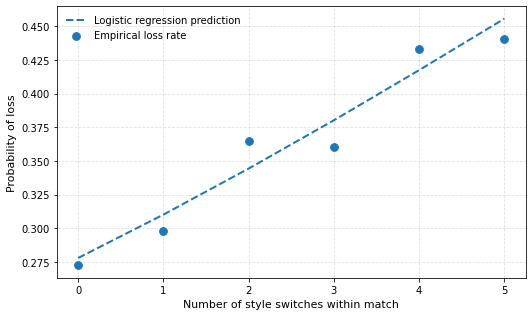

In [88]:
import numpy as np

# prediction range
x_vals = np.arange(
    match_level_df["match_change_count"].min(),
    match_level_df["match_change_count"].max() + 1
)

X_pred = sm.add_constant(x_vals)
y_pred = logit.predict(X_pred)

plt.figure(figsize=(7.5, 4.5))

plt.plot(
    x_vals,
    y_pred,
    linestyle="--",
    linewidth=2,
    label="Logistic regression prediction"
)

plt.scatter(
    loss_by_switch["match_change_count"],
    loss_by_switch["Loss"],
    s=60,
    zorder=3,
    label="Empirical loss rate"
)

plt.xlabel("Number of style switches within match", fontsize=11)
plt.ylabel("Probability of loss", fontsize=11)
plt.xticks(x_vals)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


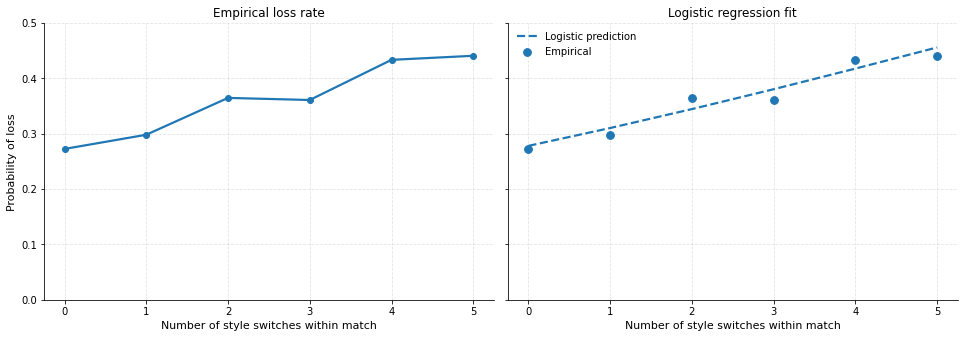

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# ---------- empirical loss by switch ----------
loss_by_switch = (
    match_level_df
    .groupby("match_change_count")["Loss"]
    .mean()
    .reset_index()
)

x = loss_by_switch["match_change_count"].to_numpy()
y = loss_by_switch["Loss"].to_numpy()

# ---------- logistic prediction ----------
x_vals = np.arange(
    match_level_df["match_change_count"].min(),
    match_level_df["match_change_count"].max() + 1
)

X_pred = sm.add_constant(x_vals)
y_pred = logit.predict(X_pred)

# ---------- figure ----------
fig, axes = plt.subplots(
    1, 2,
    figsize=(13.5, 4.8),
    sharey=True
)

# --- LEFT: empirical loss rates ---
axes[0].plot(
    x, y,
    marker="o",
    linewidth=2.2
)

axes[0].set_title("Empirical loss rate", fontsize=12)
axes[0].set_xlabel("Number of style switches within match", fontsize=11)
axes[0].set_ylabel("Probability of loss", fontsize=11)
axes[0].set_xticks(x)
axes[0].set_ylim(0, 0.5)
axes[0].grid(True, linestyle="--", alpha=0.35)

# --- RIGHT: logistic regression fit ---
axes[1].plot(
    x_vals, y_pred,
    linestyle="--",
    linewidth=2.2,
    label="Logistic prediction"
)

axes[1].scatter(
    x, y,
    s=60,
    zorder=3,
    label="Empirical"
)

axes[1].set_title("Logistic regression fit", fontsize=12)
axes[1].set_xlabel("Number of style switches within match", fontsize=11)
axes[1].set_xticks(x_vals)
axes[1].grid(True, linestyle="--", alpha=0.35)
axes[1].legend(frameon=False)

# ---------- global polish ----------
for ax in axes:
    ax.tick_params(axis="both", labelsize=10)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


# Style popularity

In [98]:
style_popularity = (
    window_match_df
    .groupby(["window", "Cluster"])
    .size()
    .reset_index(name="count")
)

# normalize within each window
style_popularity["share"] = (
    style_popularity
    .groupby("window")["count"]
    .transform(lambda x: x / x.sum())
)


<ipython-input-107-c9bcebee9828>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(t*100)}%" for t in yticks])


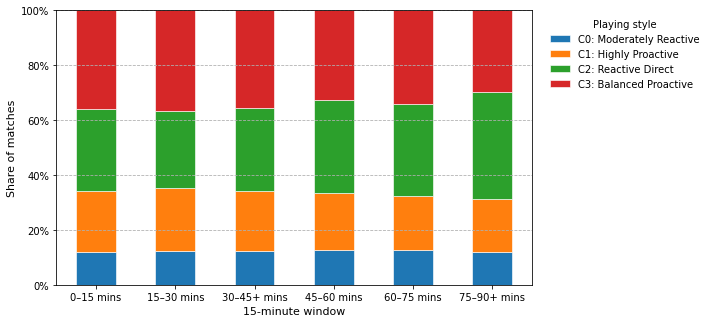

In [107]:
import re
import matplotlib.pyplot as plt

legend_labels = [
    "C0: Moderately Reactive",
    "C1: Highly Proactive",
    "C2: Reactive Direct",
    "C3: Balanced Proactive"
]

WINDOWS = [
    'final_in_poss_df_1H_0_15.csv',
    'final_in_poss_df_1H_15_30.csv',
    'final_in_poss_df_1H_30_45.csv',
    'final_in_poss_df_2H_0_15.csv',
    'final_in_poss_df_2H_15_30.csv',
    'final_in_poss_df_2H_30_45.csv'
]

# --- 1) helper: window filename -> readable label ---
def window_label(fname: str) -> str:
    # expects patterns like "..._1H_0_15.csv" or "..._2H_30_45.csv"
    m = re.search(r'_(1H|2H)_(\d+)_(\d+)\.csv$', fname)
    if not m:
        return fname

    half = m.group(1)          # 1H or 2H
    a = int(m.group(2))        # start minute in that half (0/15/30)
    b = int(m.group(3))        # end minute in that half (15/30/45)

    # map to absolute minutes
    base = 0 if half == "1H" else 45
    start = base + a
    end = base + b

    # add "+" for the last segment of each half
    if (half == "1H" and b == 45) or (half == "2H" and b == 45):
        return f"{start}\u2013{end}+ mins"  # en dash
    return f"{start}\u2013{end} mins"

# --- 2) build pivot table (shares) and relabel ---
pivot = style_popularity.pivot(index="window", columns="Cluster", values="share").fillna(0)

# ensure row order and rename windows
pivot = pivot.loc[WINDOWS].copy()
pivot.index = [window_label(w) for w in pivot.index]

# ensure cluster column order [0,1,2,3] and rename columns to your labels
cluster_order = sorted([c for c in pivot.columns if c in [0, 1, 2, 3]])
pivot = pivot[cluster_order]
pivot.columns = [legend_labels[c] for c in cluster_order]

# --- 3) prettier plot ---
ax = pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 4.6),
    edgecolor="white",
    linewidth=0.6
)

ax.set_ylabel("Share of matches", fontsize=11)
ax.set_xlabel("15-minute window", fontsize=11)

# y-axis as percentages (optional, but usually nicer)
ax.set_ylim(0, 1)
yticks = ax.get_yticks()
ax.set_yticklabels([f"{int(t*100)}%" for t in yticks])

# cleaner x labels
ax.tick_params(axis="x", rotation=0)
ax.grid(axis="y", linestyle="--", alpha=1)

# nicer legend placement
ax.legend(
    title="Playing style",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)
plt.tight_layout()
plt.show()


In [ ]:
27